## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.regularizers import l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], BN=True, DF=0, L2_RATIO=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units,
                      kernel_regularizer=l2(L2_RATIO),
                      name="hidden_layer"+str(i+1))(input_layer)
            
            if BN==True:
                x = BatchNormalization()(x)
                
            x = Activation("relu")(x)
            x = Dropout(DF)(x)  
        else:
            x = Dense(units=n_units,
                      kernel_regularizer=l2(L2_RATIO),
                      name="hidden_layer"+str(i+1))(x)
            
            if BN==True:
                x = BatchNormalization()(x)
                
            x = Activation("relu")(x)
            x = Dropout(DF)(x)  

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 128
MOMENTUM = 0.95

"""
建立實驗組合
"""
USE_BN = [True, False]
USE_DF = [0.0, 0.15]
L2_RTE = [0.0, 1e-8]

In [11]:
#使用迴圈建立不同的帶不同 drp_ratio 的模型並訓練
import itertools

results = {}
for BatchNormal, drp_ratio, l2_ratio  in itertools.product(USE_BN, USE_DF, L2_RTE):
  
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:], BN=BatchNormal, DF=drp_ratio, L2_RATIO=l2_ratio)
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "bn(%s)/df(%s)/rt(%s)" % (str(BatchNormal),str(drp_ratio),str(l2_ratio))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 350us/step - loss: 1.9250 - accuracy: 0.3256 - val_loss: 1.6737 - val_accuracy: 0.4138
Epoch 2/10
50000/50000 [==============================] - 16s 315us/step - loss: 1.6559 - accuracy: 0.4096 - val_loss: 1.5484 - val_accuracy: 0.4598
Epoch 3/10
50000/50000 [==============================] - 16s 312us/step - loss: 1.5607 - accuracy: 0.4443 - val_loss: 1.5320 - val_accuracy: 0.4535
Epoch 4/10
50000/50000 [==============================] - 15s 309us/step - loss: 1.4952 - accuracy: 0.4672 - val_loss: 1.4945 - val_accuracy: 0.4704
Epoch 5/10
50000/50000 [==============================] - 15s 308us/step - loss: 1.4496 - accuracy: 0.4827 - val_loss: 1.4371 - val_accuracy: 0.4908
Epoch 6/10
50000/50000 [==============================] - 15s 305us/step - loss: 1.4089 - accuracy: 0.4980 - val_loss: 1.5244 - val_accuracy: 0.4524
Epoch 7/10
50000/50000 [==============================] 

Epoch 8/10
50000/50000 [==============================] - 14s 283us/step - loss: 1.4059 - accuracy: 0.5045 - val_loss: 1.4216 - val_accuracy: 0.4941
Epoch 9/10
50000/50000 [==============================] - 15s 291us/step - loss: 1.3728 - accuracy: 0.5152 - val_loss: 1.4459 - val_accuracy: 0.4859
Epoch 10/10
50000/50000 [==============================] - 14s 287us/step - loss: 1.3433 - accuracy: 0.5261 - val_loss: 1.4050 - val_accuracy: 0.5004
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 348us/step - loss: 2.0486 - accuracy: 0.2520 - val_loss: 1.8443 - val_accuracy: 0.3468
Epoch 2/10
50000/50000 [==============================] - 19s 377us/step - loss: 1.8429 - accuracy: 0.3368 - val_loss: 1.7252 - val_accuracy: 0.3936
Epoch 3/10
50000/50000 [==============================] - 18s 369us/step - loss: 1.7573 - accuracy: 0.3687 - val_loss: 1.6599 - val_accuracy: 0.4130
Epoch 4/10
50000/50000 [==============================] - 20s 401us/step - loss: 1.6987 - accuracy: 0.3925 - val_loss: 1.6095 - val_accuracy: 0.4280
Epoch 5/10
50000/50000 [==============================] - 18s 368us/step - loss: 1.6546 - accuracy: 0.4107 - val_loss: 1.5766 - val_accuracy: 0.4384
Epoch 6/10
50000/50000 [==============================] - 18s 367us/step - loss: 1.6163 - accuracy: 0.4250 - val_loss: 1.5398 - val_accuracy: 0.4551
Epoch 7/10
50000/50000 [==============================] 

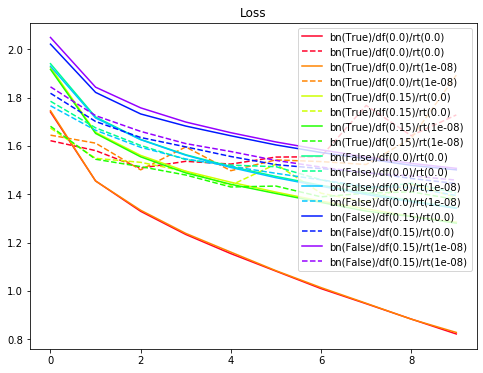

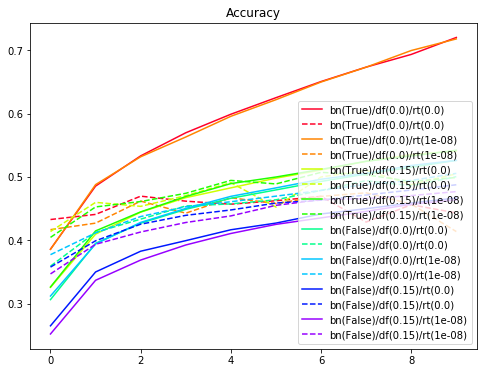

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()